# Question 3.3

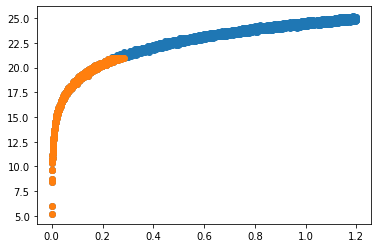

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from scipy.stats import norm,binom

h = 0.7324
M0 = -19.5
Om0 = 0.32
sigma_int=0.1
m_cut = 21
sigma_cut =0.01


sc = 2.47
u=np.random.rand(10000)*sc
z_s= ((5/2 * (u+2/5))**(2/5)-1 )


cosmo = FlatLambdaCDM(H0=h*100, Om0=Om0)
    
d_s = cosmo.luminosity_distance(z_s).value


mu_s=5*np.log10(d_s*1e6/10)

m_s = mu_s + M0 + np.random.normal(size=len(z_s))*sigma_int

p_s=norm.cdf(-m_s, loc=-m_cut, scale=sigma_cut)
  

sel_s=binom.rvs(1,p_s,size=len(p_s))

plt.scatter(z_s,m_s)
plt.scatter(z_s[sel_s==1],m_s[sel_s==1])
plt.show()

z_s = z_s[sel_s==1]
m_s = m_s[sel_s==1]



In [19]:
import numpy as np
from matplotlib import pyplot as plt
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from jax import random
import jax
from jax.example_libraries import stax, optimizers
from jax.scipy.stats import norm
from jax.scipy.special import ndtri
#assert numpyro.__version__.startswith("0.11.0")

numpyro.set_host_device_count(4)
jax.config.update('jax_enable_x64',True)
import pickle

import jax_cosmo as jc
from jax_cosmo import Cosmology, background

from astropy.cosmology import FlatLambdaCDM,wCDM
from astropy.coordinates import Distance

from numpyro import sample

import numpyro.distributions as dist

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from numpyro.distributions.truncated import TruncatedDistribution 
from numpyro.distributions import (
    Distribution,
    constraints)
from numpyro.distributions.util import is_prng_key, promote_shapes, validate_sample
from jax import lax
from SkewNormalPlus import SkewNormalPlus
import pickle
import numpyro
from NSF import NeuralSpline1D
from flow import Normal,Flow,transform,Serial
from SkewNormalPlus import SkewNormalPlus as snp

@jit
def minmax_fit_and_scale(X):
  max= jnp.max(X,axis=0)
  min = jnp.min(X,axis=0)
  X_std = (X - min) / (max-min)
  return X_std,min,max

@jit
def minmax_scale(X,min,max):
  return (X - min) / (max - min)

@jit
def minmax_unscale(X,min,max):
  return X * (max - min) + min

from jax.example_libraries import stax, optimizers

from jax.example_libraries.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, Softmax, Exp,Sigmoid,Softplus,LeakyRelu)

def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Relu, stax.Dense(1024),  Relu, stax.Dense(1024),Relu,stax.Dense(hidden_dim), Relu, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))

    return params,apply_fun

rng, flow_rng = random.split(random.PRNGKey(0))

init_fun = Flow(Serial(*(NeuralSpline1D(network,hidden_dim=256,K=20,B=3),)*5),prior=Normal())

_, log_pdf_flow, sample_flow = init_fun(flow_rng,2 )


file = jnp.load('flow2d.npz',allow_pickle=True)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)

opt_params = pickle.load(open('flow2d_opt.pkl', "rb"))
opt_state = optimizers.pack_optimizer_state(opt_params)

params = get_params(opt_state)



min_file = jnp.asarray(file['min'])
max_file = jnp.asarray(file['max'])
diff_scale = jnp.log(max_file[0]-min_file[0])

class FlowSNP(Distribution):
    arg_constraints = {"m_int": constraints.real, "sigma_int": constraints.real,"m_cut": constraints.real, "sigma_cut": constraints.real}
    support = constraints.real
    reparametrized_params = ["m_int", "sigma_int","m_cut","sigma_cut"]

    def __init__(self,m_int,sigma_int,m_cut,sigma_cut,*, validate_args=None,res=1000):


        self.min = min_file
        self.max = max_file




        self.m_int, self.sigma_int,self.m_cut,self.sigma_cut = promote_shapes(m_int,sigma_int,m_cut,sigma_cut)


        batch_shape = lax.broadcast_shapes(jnp.shape(m_int), jnp.shape(sigma_int),jnp.shape(m_int), jnp.shape(sigma_int))

        n_obj = m_int.shape[0]


        self.n_obj=n_obj



        super(FlowSNP, self).__init__(
            batch_shape=batch_shape, validate_args=validate_args
        )


    def sample(self,key, sample_shape=()):
        assert is_prng_key(key)



        no_samps = sample_shape[0]

        self.no_samps = no_samps

        m_col =  jnp.repeat(self.m_int.reshape(self.n_obj),no_samps).reshape(no_samps*self.n_obj,1)

        theta = jnp.column_stack((m_col,jnp.repeat(self.sigma_int,no_samps*self.n_obj).reshape(no_samps*self.n_obj,1)))



        samp=sample_flow(key, params,minmax_scale(theta,jnp.asarray(self.min[1:]),np.asarray(self.max[1:])),num_samples=self.no_samps*self.n_obj)

        samp = minmax_unscale(samp[:,0],self.min[0],self.max[0]).reshape(no_samps*self.n_obj,1) + m_col



        return samp.reshape(self.n_obj,self.no_samps).T


    @jax.jit
    def log_prob(self, value):

        no_samps = 1
        no_obj = value.shape[0]


        value=value.T.reshape(no_samps*no_obj,)
        value = value.reshape(no_samps*no_obj,1)


        m_col = self.m_int.reshape(no_obj,1)

        theta=jnp.column_stack((m_col,jnp.repeat(self.sigma_int,no_obj).reshape(no_obj,1)))

        theta = jnp.repeat(theta,no_samps,axis=0)

        value = value -theta[:,:1]

        X=jnp.asarray(minmax_scale(jnp.column_stack((value,theta)),min_file,max_file))


        prob = log_pdf_flow(params,X)
        prob = prob.reshape(no_obj*no_samps,)
        prob=prob.reshape(no_obj,no_samps).T - diff_scale


        return prob 




In [25]:

from SkewNormalPlus import SkewNormalPlus

n_sne = len(z_s)



def logpost(M,log_sigma_int,log_omega_m,mode='naive'):
    
    
    
    omega_m = np.exp(log_omega_m)
    sigma_int = np.exp(log_sigma_int)
    
    
    cosmo = FlatLambdaCDM(H0=h*100, Om0=omega_m)
    
    d_s = cosmo.luminosity_distance(z_s).value


    mu_s=5*np.log10(d_s*1e6/10)

    m0_s = mu_s + M
    
    if mode=='naive':
        
        log_likelihood = -n_sne*np.log(sigma_int*np.sqrt(2*np.pi)) -0.5*(1/sigma_int**2)*np.sum((m_s-m0_s)**2)
    
    elif mode=='flow':
        
        snp=FlowSNP(m_int=m0_s,sigma_int=sigma_int,m_cut=m_cut,sigma_cut=sigma_cut)
        
        log_likelihood = np.sum(snp.log_prob(m_s))
        
    else:
        
        snp=SkewNormalPlus(m_int=m0_s,sigma_int=sigma_int,m_cut=m_cut,sigma_cut=sigma_cut)
        
        log_likelihood = np.sum(snp.log_prob(m_s,mcmc=True))
        

    log_prior=0

    return log_likelihood + log_prior




def run_mc(n_mc,mode='naive'):



    mc = np.zeros((n_mc,3))




    M = -19.4
    log_sigma_int = np.log(0.08)
    log_omega_m = np.log(0.3)



    logpost_curr = logpost(M,log_sigma_int,log_omega_m,mode=mode)



    sigma_prop_M = 0.01
    sigma_prop_sig = 0.01
    sigma_prop_m = 0.01




    print('Running MCMC for '+str(n_mc)+' steps...')

    for i in range(n_mc):
    

    
        M_prop = M + sigma_prop_M*np.random.normal()
    
        sig_prop = log_sigma_int + sigma_prop_sig*np.random.normal()
    
        m_prop = log_omega_m + sigma_prop_m*np.random.normal()
    
        logpost_prop = logpost(M_prop,sig_prop,m_prop,mode=mode)
    
        logr = logpost_prop - logpost_curr
    

        if np.log(np.random.rand()) <= logr:
    
            M = M_prop 
    
            log_sigma_int =sig_prop 
    
            log_omega_m = m_prop
        
            
            logpost_curr = logpost_prop
    
 
        
        mc[i,:] = np.array([M,log_sigma_int,log_omega_m])
        
        if i%100==0:
            print(i)

    return mc


    


In [21]:
naive_samps = run_mc(20000,mode='naive')

Running MCMC for 20000 steps...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


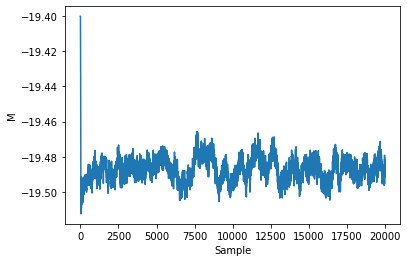

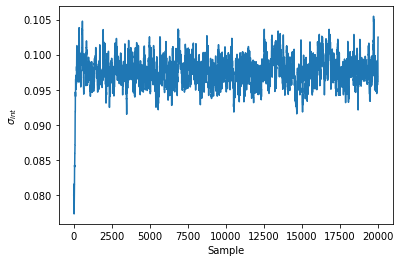

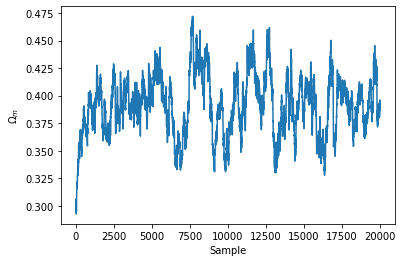

In [8]:
from matplotlib import pyplot as plt
plt.plot(naive_samps[:,0])
plt.xlabel('Sample')
plt.ylabel('M')
plt.show()
plt.plot(np.exp(naive_samps[:,1]))
plt.xlabel('Sample')
plt.ylabel(r'$\sigma_{int}$')
plt.show()
plt.plot(np.exp(naive_samps[:,2]))
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{m}$')
plt.show()


In [6]:
correct_samps = run_mc(20000,mode='true')

Running MCMC for 20000 steps...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


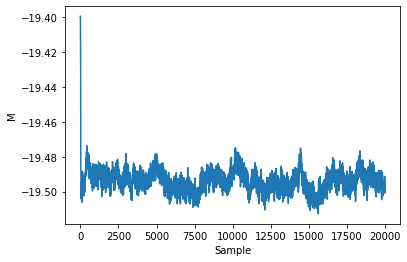

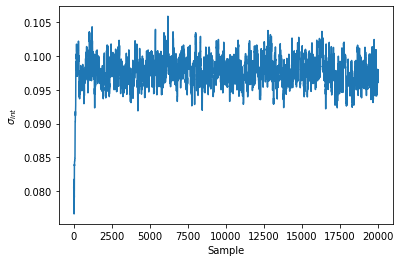

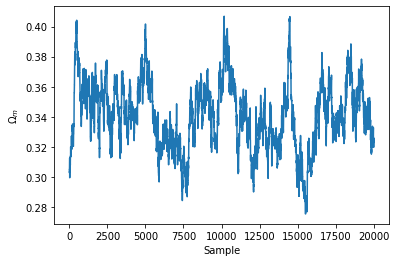

In [9]:
from matplotlib import pyplot as plt
plt.plot(correct_samps[:,0])
plt.xlabel('Sample')
plt.ylabel('M')
plt.show()
plt.plot(np.exp(correct_samps[:,1]))
plt.xlabel('Sample')
plt.ylabel(r'$\sigma_{int}$')
plt.show()
plt.plot(np.exp(correct_samps[:,2]))
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{m}$')
plt.show()


In [26]:
flow_samps = run_mc(20000,mode='flow')

Running MCMC for 20000 steps...
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900


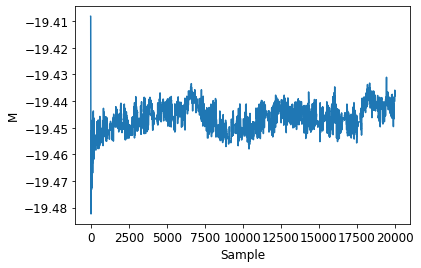

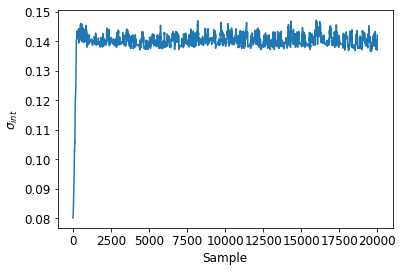

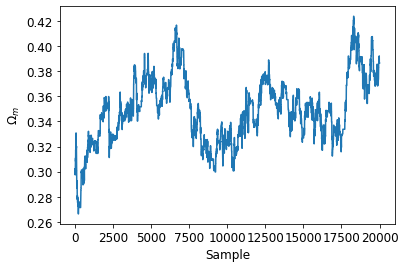

In [27]:
from matplotlib import pyplot as plt
plt.plot(flow_samps[:,0])
plt.xlabel('Sample')
plt.ylabel('M')
plt.show()
plt.plot(np.exp(flow_samps[:,1]))
plt.xlabel('Sample')
plt.ylabel(r'$\sigma_{int}$')
plt.show()
plt.plot(np.exp(flow_samps[:,2]))
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{m}$')
plt.show()


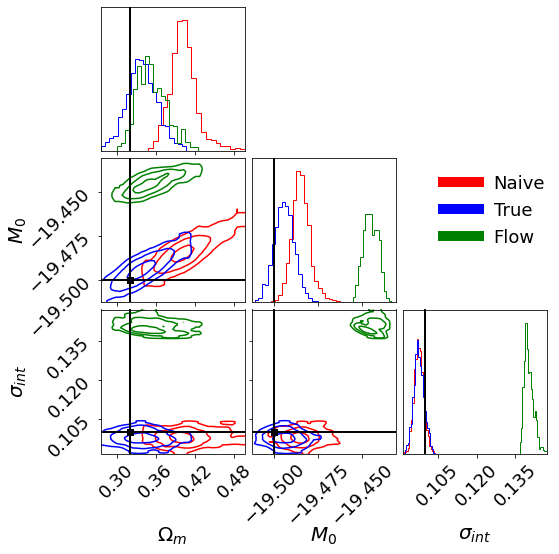

In [28]:
import corner
import matplotlib.lines as mlines
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
labels_plot=[r'$\Omega_m$',r'$M_0$',r'$\sigma_{int}$']
plot_naive= np.array([np.exp(naive_samps[int(len(naive_samps)/2):,2]),naive_samps[int(len(naive_samps)/2):,0],np.exp(naive_samps[int(len(naive_samps)/2):,1])]).T
fig=corner.corner(plot_naive,labels=labels_plot,truths=[0.32,-19.5,0.1],smooth=0.9,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2),1 - np.exp(-9 / 2.)),
    label_kwargs=dict(fontsize=20),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=3,truth_color='black',color='red',labelpad=0.2,title_fmt='.3f')

plot_correct= np.array([np.exp(correct_samps[int(len(correct_samps)/2):,2]),correct_samps[int(len(correct_samps)/2):,0],np.exp(correct_samps[int(len(correct_samps)/2):,1])]).T
corner.corner(plot_correct,labels=labels_plot,truths=[0.32,-19.5,0.1],smooth=0.9,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2),1 - np.exp(-9 / 2.)),
    label_kwargs=dict(fontsize=20),
    plot_density=False,
    plot_datapoints=False,
   fill_contours=False,
    show_titles=False,
    max_n_ticks=4,truth_color='black',color='blue',labelpad=0.2,title_fmt='.3f',fig=fig)

plot_flow= np.array([np.exp(flow_samps[int(len(flow_samps)/2):,2]),flow_samps[int(len(flow_samps)/2):,0],np.exp(flow_samps[int(len(flow_samps)/2):,1])]).T
corner.corner(plot_flow,labels=labels_plot,truths=[0.32,-19.5,0.1],smooth=0.9,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2),1 - np.exp(-9 / 2.)),
    label_kwargs=dict(fontsize=20),
    plot_density=False,
    plot_datapoints=False,
   fill_contours=False,
    show_titles=False,
    max_n_ticks=4,truth_color='black',color='green',labelpad=0.2,title_fmt='.3f',fig=fig)


red_line = mlines.Line2D([], [], color='red', label=r'Naive',linewidth=10)
blue_line = mlines.Line2D([], [], color='blue', label=r'True',linewidth=10)
green_line = mlines.Line2D([], [], color='green', label=r'Flow',linewidth=10)
plt.legend(handles=[red_line,blue_line,green_line], frameon=False,bbox_to_anchor=(1, 2, 0.1, 0.05),loc='upper right')
plt.show()
matplotlib.rcParams.update({'font.size': 12})

# Question 3.4

In [ ]:

from astropy.cosmology import wCDM



n_sne = len(zs)



def logpost2(M,log_sigma_int,log_omega_m,w,prior='uniform'):
    
    
    
    omega_m = np.exp(log_omega_m)
    sigma_int = np.exp(log_sigma_int)
    
    omega_l = 1-omega_m
    
    cosmo = wCDM(H0=72, Om0=omega_m, Ode0=omega_l,w0=w)
    
    d = cosmo.luminosity_distance(zs)
    
    d = d.value
    
    mo = M + 25 + 5*np.log10(3e5*d / 100)
    
    
    
    
    
    log_likelihood = -n_sne*np.log(sigma_int*np.sqrt(2*np.pi)) -0.5*(1/sigma_int**2)*np.sum((ms-mo)**2)
    log_prior = 0
    
    if prior == 'cmb':
        
        cmb_sig = np.sqrt(0.04/1.41)
        
        cmb_mu = ((1.3-omega_m)/1.41)
        

        log_prior +=-np.log(cmb_sig*np.sqrt(2*np.pi)) -0.5*(1/cmb_sig**2)*(omega_l-cmb_mu)**2
        

    return log_likelihood + log_prior




def run_mc2(n_mc,prior='uniform'):



    mc = np.zeros((n_mc,4))

    acc = 0

    M = -38 - 5*np.log10(0.72)
    log_sigma_int = np.log(0.1)
    log_omega_m = np.log(0.3)
    w = -1


    logpost_curr = logpost2(M,log_sigma_int,log_omega_m,w,prior=prior)


    sigma_prop_M = 0.01
    sigma_prop_sig = 0.01
    sigma_prop_m = 0.01
    sigma_prop_w = 0.01




    print('Running MCMC for '+str(n_mc)+' steps...')

    for i in range(n_mc):
        

    

    
        M_prop = M + sigma_prop_M*np.random.normal()
    
        sig_prop = log_sigma_int + sigma_prop_sig*np.random.normal()
    
        m_prop = log_omega_m + sigma_prop_m*np.random.normal()
    
        w_prop= w + sigma_prop_w*np.random.normal()
    
    
        logpost_prop = logpost2(M_prop,sig_prop,m_prop,w_prop,prior=prior)

    
        logr = logpost_prop - logpost_curr
    

        if np.log(np.random.rand()) <= logr:
        

        

        
    
            M = M_prop 
    
            log_sigma_int =sig_prop 
    
            log_omega_m = m_prop
    
            w = w_prop 
        
            logpost_curr = logpost_prop
    
        

        
        mc[i,:] = np.array([M,log_sigma_int,log_omega_m,w])
    return mc


    


In [ ]:
uniform_samps = run_mc2(100000,prior='uniform')

In [ ]:
from matplotlib import pyplot as plt
plt.plot(uniform_samps[:,0])
plt.xlabel('Sample')
plt.ylabel('M')
plt.show()
plt.plot(np.exp(uniform_samps[:,1]))
plt.xlabel('Sample')
plt.ylabel(r'$\sigma_{int}$')
plt.show()
plt.plot(np.exp(uniform_samps[:,2]))
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{m}$')
plt.show()
plt.plot(uniform_samps[:,3])
plt.xlabel('Sample')
plt.ylabel('w')
plt.show()

In [ ]:
cmb_samps = run_mc2(100000,prior='cmb')

In [ ]:
plt.plot(cmb_samps[:,0])
plt.xlabel('Sample')
plt.ylabel('M')
plt.show()
plt.plot(np.exp(cmb_samps[:,1]))
plt.xlabel('Sample')
plt.ylabel(r'$\sigma_{int}$')
plt.show()
plt.plot(np.exp(cmb_samps[:,2]))
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{m}$')
plt.show()
plt.plot(uniform_samps[:,3])
plt.xlabel('Sample')
plt.ylabel('w')
plt.show()

Compare uniform vs CMB samples

In [ ]:
plt.scatter(np.exp(uniform_samps[60000:,2]),uniform_samps[60000:,3],color='blue',label='Uniform')
plt.scatter(np.exp(cmb_samps[60000:,2]),cmb_samps[60000:,3],color='red',label='CMB')
plt.legend(frameon=False)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'w')
plt.show()


In [ ]:
import corner
import matplotlib.lines as mlines
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
labels_plot=[r'$\Omega_m$',r'w']
plot_uniform = np.array([np.exp(uniform_samps[60000:,2]),uniform_samps[60000:,3]]).T
fig=corner.corner(plot_uniform,labels=labels_plot,smooth=0.9,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    label_kwargs=dict(fontsize=20),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=4,truth_color='black',color='blue',labelpad=0,title_fmt='.3f')
plot_cmb = np.array([np.exp(cmb_samps[60000:,2]),cmb_samps[60000:,3]]).T
corner.corner(plot_cmb,labels=labels_plot,smooth=0.9,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    label_kwargs=dict(fontsize=20),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=4,truth_color='black',color='red',labelpad=0,title_fmt='.3f',fig=fig)


blue_line = mlines.Line2D([], [], color='blue', label=r'Uniform',linewidth=10)
red_line = mlines.Line2D([], [], color='red', label=r'CMB',linewidth=10)
plt.legend(handles=[blue_line,red_line], frameon=False,bbox_to_anchor=(1, 2, 0.1, 0.05),loc='upper right')
plt.show()
matplotlib.rcParams.update({'font.size': 12})